In [1]:
import torch
import torchvision
import random
from PIL import Image
from torch import nn
from torchvision import transforms
from torchinfo import summary
import matplotlib.pyplot as plt
import os
from pathlib import Path
import shutil
from torchvision import datasets
from torch.utils.data import DataLoader
import ssl
import torcheval
from torcheval.metrics import BinaryAccuracy
from tqdm.auto import tqdm


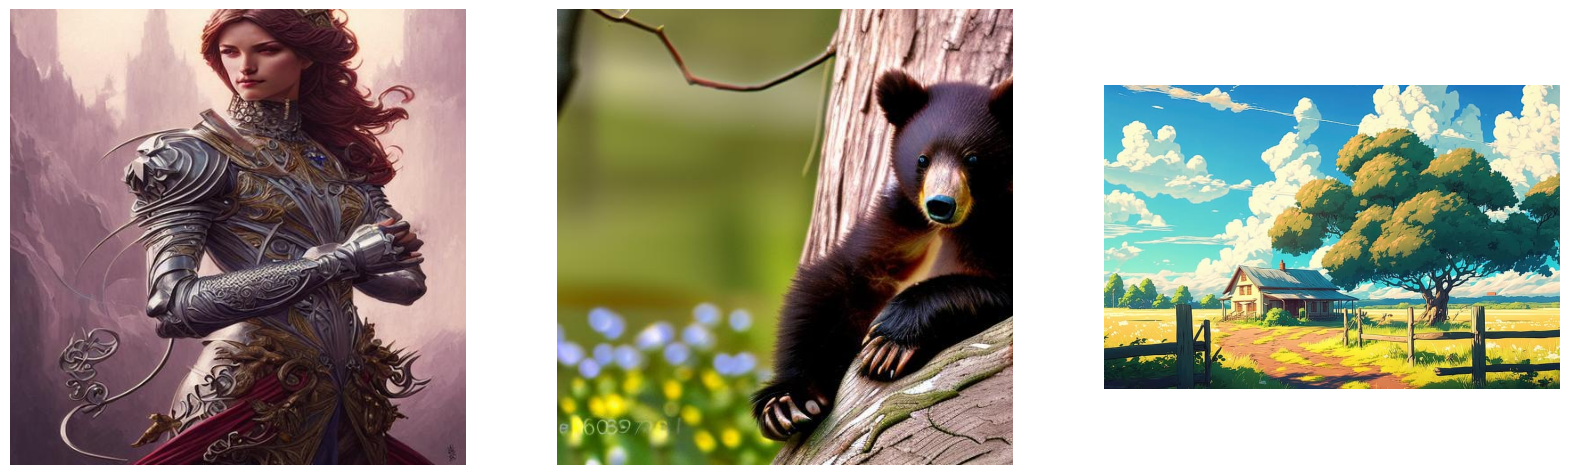

In [2]:
# This snippet loads and displays three random JPEG images from a specified AI art directory using PyTorch, PIL, and Matplotlib libraries.
data_path = Path("archive")
ai_dir = data_path / "Aidata" / "Aidata"
real_dir = data_path / "Realdata" / "Realdata" 
ai_image_path_list = list(Path(ai_dir).glob("*.jpg"))
random_ai_image = random.sample(ai_image_path_list, k=3)
plt.figure(figsize=(20, 15))

i = 1
for image_path in random_ai_image:
    plt.subplot(1, 3, i)
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis(False)
    i += 1

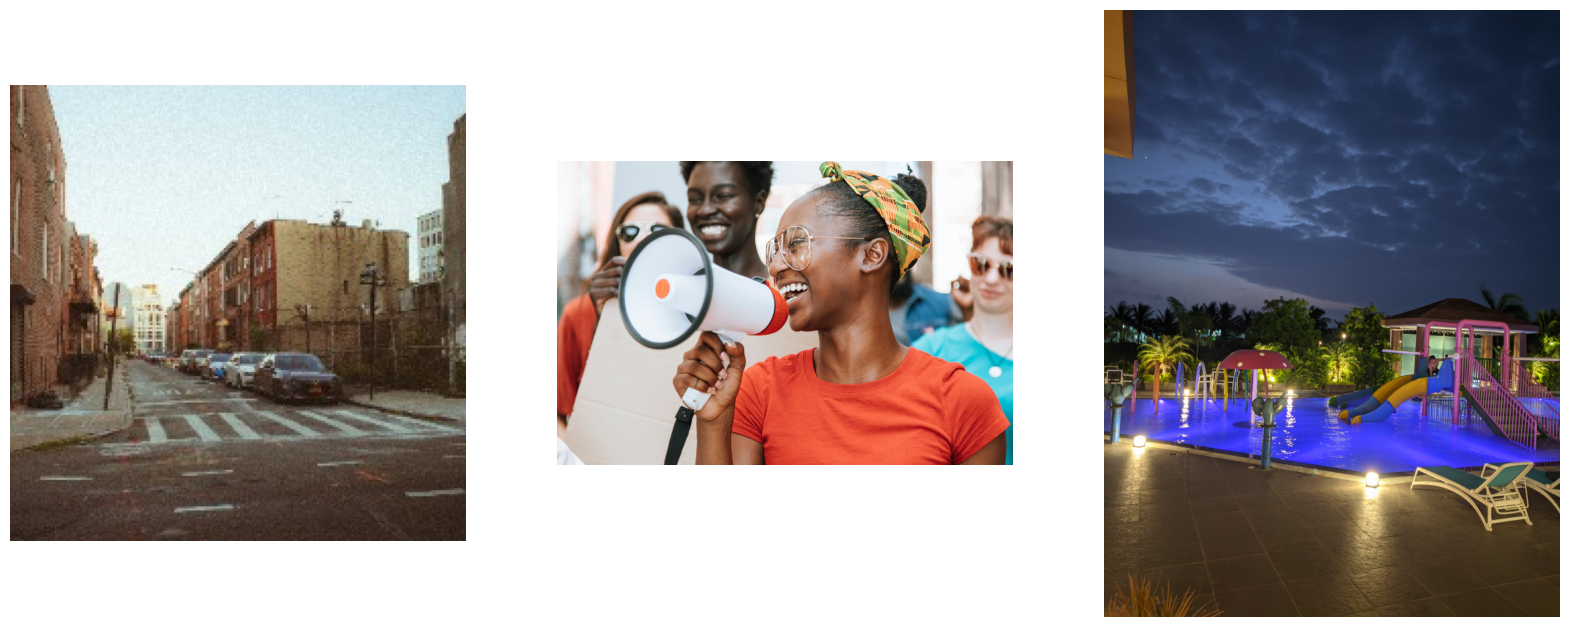

In [3]:
# Loading and displaying three random JPEG images from the specified real art directory using PyTorch, PIL, and Matplotlib.
real_image_path_list = list(Path(real_dir).glob("*.jpg"))
random_real_image = random.sample(real_image_path_list, k=3)
plt.figure(figsize=(20, 15))

i = 1
for image_path in random_real_image:
    plt.subplot(1, 3, i)
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis(False)
    i += 1

In [4]:
# Creating training and testing directories, splitting AI and real art images into training and testing sets, and displaying counts for each category.

new_data_path = Path("working/data")
new_data_path.mkdir(parents=True, exist_ok=True)

train_path = new_data_path / "train"
test_path = new_data_path / "test"

os.mkdir(train_path)
os.mkdir(test_path)

train_ai_split = int(len(ai_image_path_list) * 0.8)
train_real_split = int(len(real_image_path_list) * 0.8)

train_ai_img = random.sample(ai_image_path_list, k=train_ai_split)
train_real_img = random.sample(real_image_path_list, k=train_real_split)

test_ai_img = []
test_real_img = []

for ai_img in ai_image_path_list:
    if ai_img not in train_ai_img:
        test_ai_img.append(ai_img)
    
for real_img in real_image_path_list:
    if real_img not in train_real_img:
        test_real_img.append(real_img)
print(f"ai_image_path_list: {len(ai_image_path_list)}")
print(f"real_image_path_list: {len(real_image_path_list)}")
print(f"train_ai_img: {len(train_ai_img)}")
print(f"train_real_img: {len(train_real_img)}")
print(f"test_ai_img: {len(test_ai_img)}")
print(f"test_real_img: {len(test_real_img)}")

ai_image_path_list: 2116
real_image_path_list: 3951
train_ai_img: 1692
train_real_img: 3160
test_ai_img: 424
test_real_img: 791


In [5]:
# Creating subdirectories for AI and real art in both train and test paths, and copying the respective images into these directories.
train_ai_path = train_path / "Ai"
train_real_path = train_path / "Real"
test_ai_path = test_path / "Ai"
test_real_path = test_path / "Real"

os.mkdir(train_ai_path)
os.mkdir(train_real_path)
os.mkdir(test_ai_path)
os.mkdir(test_real_path)

for img in train_ai_img:
    shutil.copy(img, train_ai_path)
for img in train_real_img:
    shutil.copy(img, train_real_path)
for img in test_ai_img:
    shutil.copy(img, test_ai_path)
for img in test_real_img:
    shutil.copy(img, test_real_path)

In [6]:
weights = torchvision.models.ResNet152_Weights.DEFAULT
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [7]:
# Loading training and testing datasets from their respective directories, applying transformations, and listing the class names.

train_data = datasets.ImageFolder(root=train_path,
                                 transform=auto_transforms)
test_data = datasets.ImageFolder(root=test_path,
                                transform=auto_transforms)
class_names = train_data.classes
print(f"Train data:\n{train_data}\nTest data:\n{test_data}")
class_names

Train data:
Dataset ImageFolder
    Number of datapoints: 4852
    Root location: working/data/train
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[232]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 1215
    Root location: working/data/test
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[232]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )


['Ai', 'Real']

In [8]:

# Creating data loaders for the train and test datasets with specified batch sizes and worker threads, enabling shuffling for training data.


# ssl._create_default_https_context = ssl._create_unverified_context
# data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
num_workers = os.cpu_count()
train_dataloader = DataLoader(dataset=train_data,
                             batch_size=32,
                             num_workers=num_workers,
                             shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                            batch_size=32,
                            num_workers=num_workers,
                            shuffle=False)
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x177c58550>,
 <torch.utils.data.dataloader.DataLoader at 0x1765b3410>)

In [9]:
# Setting up the device for model operations, initializing a ResNet152 model with pre-trained weights, and moving it to the specified device.

device="mps"
model = torchvision.models.resnet152(weights="IMAGENET1K_V2").to(device)
print(next(model.parameters()).dtype)


torch.float32


In [10]:
summary(model=model,
        input_size=(32, 3, 224, 224),
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     4,096                True
│    │    └─BatchN

In [11]:
# Freezing the parameters in all layers of the model to prevent them from updating during training.


for param in model.conv1.parameters():
    param.requires_grad = False
for param in model.bn1.parameters():
    param.requires_grad = False
for param in model.layer1.parameters():
    param.requires_grad = False
for param in model.layer2.parameters():
    param.requires_grad = False
for param in model.layer3.parameters():
    param.requires_grad = False
for param in model.layer4.parameters():
    param.requires_grad = False

In [12]:
summary(model=model,
        input_size=(32, 3, 224, 224),
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1000]           --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

In [13]:
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [14]:
# Replacing the fully connected layer of the model with a new sequence including dropout and linear transformations.

model.fc = nn.Sequential(
nn.Dropout(p=0.5),   
nn.Linear(in_features=2048, out_features=1024, bias=True),
nn.Dropout(p=0.5),
nn.Linear(in_features=1024, out_features=1, bias=True),
)
model.fc

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=2048, out_features=1024, bias=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=1024, out_features=1, bias=True)
)

In [15]:
summary(model=model,
        input_size=(32, 3, 224, 224),
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 1]              --                   Partial
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   (9,408)              False
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     (4,096)              False
│    │    

In [16]:
# Initializing the binary cross-entropy loss function and setting up the Adam optimizer with learning rate adjustments for the model.
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [17]:
# Defining a function to compute accuracy using a binary accuracy metric with a threshold of 0.5.

def accuracy_fn(y_true: torch.Tensor, y_pred: torch.Tensor):
    metric = BinaryAccuracy(threshold=0.5)
    metric.update(y_pred, y_true)
    return metric.compute().item()

In [18]:
accuracy_fn(torch.tensor([0, 0, 0, 1]), torch.Tensor([0.2, 0.9, 0.9, 0.9]))

0.5

In [19]:
# Transferring the model and a batch of images to the designated device, performing a forward pass, and displaying the raw and sigmoid-activated predictions.

model.to(device)
img, label = next(iter(train_dataloader))
img = img.to(device)
print(img.dtype)
model(img)
pred = model(img)

print(pred.squeeze())
print(torch.sigmoid(pred.squeeze()))
pred.squeeze().shape, label.shape



torch.float32
tensor([-0.1561,  0.1021, -0.2752, -0.2940, -0.0290, -0.2136,  0.1186, -0.0991,
         0.0739, -0.2155, -0.0751, -0.0487, -0.3112, -0.0031,  0.3000, -0.0811,
         0.1303,  0.0832, -0.0565,  0.0729, -0.0428, -0.4731,  0.5016, -0.0960,
        -0.0157,  0.0108, -0.0874, -0.2598, -0.3494,  0.2219,  0.1996,  0.2276],
       device='mps:0', grad_fn=<SqueezeBackward0>)
tensor([0.4610, 0.5255, 0.4316, 0.4270, 0.4927, 0.4468, 0.5296, 0.4752, 0.5185,
        0.4463, 0.4812, 0.4878, 0.4228, 0.4992, 0.5744, 0.4797, 0.5325, 0.5208,
        0.4859, 0.5182, 0.4893, 0.3839, 0.6228, 0.4760, 0.4961, 0.5027, 0.4782,
        0.4354, 0.4135, 0.5552, 0.5497, 0.5567], device='mps:0',
       grad_fn=<SigmoidBackward0>)


(torch.Size([32]), torch.Size([32]))

In [20]:
# Defining functions for training and testing steps, including model execution, loss calculation, backpropagation, and accuracy assessment.

def train_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              accuracy_fn):
    
    model.train()
    
    train_loss, train_acc = 0, 0
    
    for batch, (X, y) in enumerate(dataloader):
        
        X, y = X.to(device), y.to(device)
        
        y_pred = model(X).squeeze()
        
        loss = loss_fn(y_pred, y.float())
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_acc += accuracy_fn(y_true=y, y_pred=torch.sigmoid(y_pred))
        
    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn):
    
    model.eval()
    
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            
            test_pred_logits = model(X).squeeze()
            
            loss = loss_fn(test_pred_logits, y.float())
            test_loss += loss.item()
            
            test_acc += accuracy_fn(y_true=y, y_pred=torch.sigmoid(test_pred_logits))
            
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    
    return test_loss, test_acc

In [21]:
# Orchestrates the training process, iterating over epochs, managing training and testing steps, and collecting performance metrics.



def train(model: torch.nn.Module,
         loss_fn: torch.nn.Module,
         optimizer: torch.optim.Optimizer,
         train_dataloader: torch.utils.data.DataLoader,
         test_dataloader: torch.utils.data.DataLoader,
         accuracy_fn,
         epochs: int = 5):
    
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    for epoch in tqdm(range(epochs)):
        
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          accuracy_fn=accuracy_fn)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        accuracy_fn=accuracy_fn)
        
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )
        
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        
    return results

In [22]:
# Setting random seeds for reproducibility, timing the training session, and printing the total training duration.

torch.manual_seed(42)
print("done")
torch.mps.manual_seed(42)
print("done")

from timeit import default_timer as timer


start_time = timer()
results = train(model=model,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               train_dataloader=train_dataloader,
               test_dataloader=test_dataloader,
               epochs=15)

end_time = timer()

print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")


done
done


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.4504 | train_acc: 0.7970 | test_loss: 0.3315 | test_acc: 0.8748
Epoch: 2 | train_loss: 0.3738 | train_acc: 0.8433 | test_loss: 0.3110 | test_acc: 0.8732
Epoch: 3 | train_loss: 0.3720 | train_acc: 0.8419 | test_loss: 0.3089 | test_acc: 0.8625
Epoch: 4 | train_loss: 0.3518 | train_acc: 0.8482 | test_loss: 0.2977 | test_acc: 0.8855
Epoch: 5 | train_loss: 0.3377 | train_acc: 0.8563 | test_loss: 0.3000 | test_acc: 0.8781
Epoch: 6 | train_loss: 0.3615 | train_acc: 0.8467 | test_loss: 0.3109 | test_acc: 0.8584
Epoch: 7 | train_loss: 0.3357 | train_acc: 0.8536 | test_loss: 0.2915 | test_acc: 0.8805
Epoch: 8 | train_loss: 0.3537 | train_acc: 0.8465 | test_loss: 0.2951 | test_acc: 0.8814
Epoch: 9 | train_loss: 0.3500 | train_acc: 0.8477 | test_loss: 0.3111 | test_acc: 0.8722
Epoch: 10 | train_loss: 0.3367 | train_acc: 0.8556 | test_loss: 0.3016 | test_acc: 0.8822
Epoch: 11 | train_loss: 0.3426 | train_acc: 0.8597 | test_loss: 0.3351 | test_acc: 0.8639
Epoch: 12 | train_l

In [23]:
# Plotting loss and accuracy curves for training and testing data across epochs, using matplotlib.

from typing import Dict, List

def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    loss = results['train_loss']
    test_loss = results['test_loss']

    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

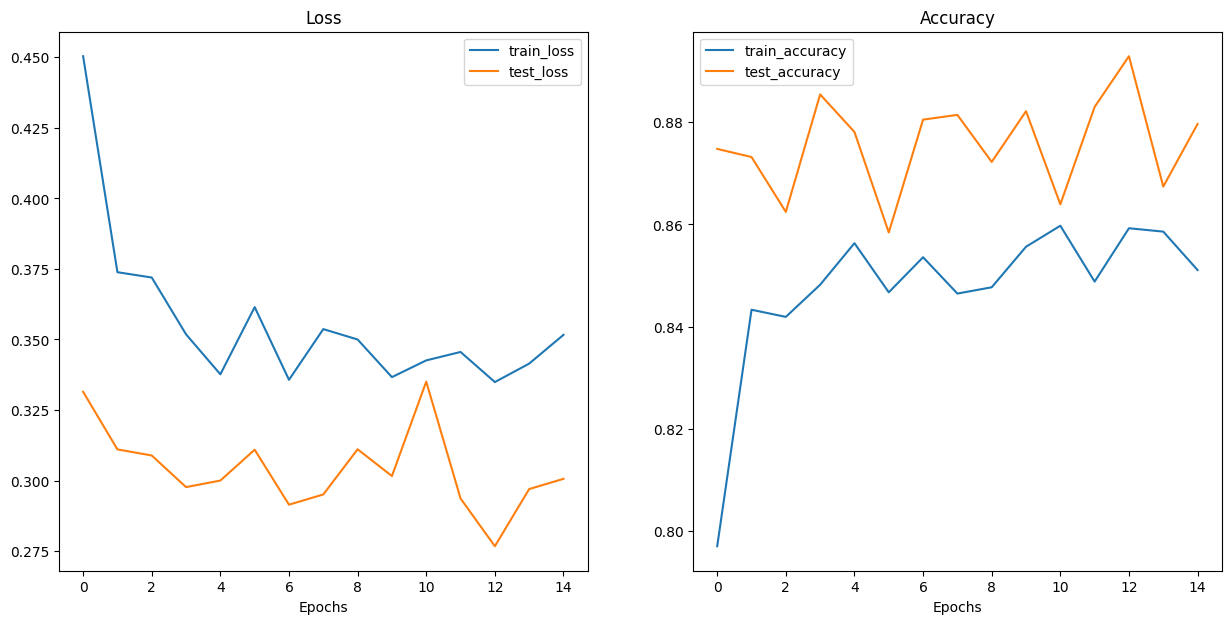

In [24]:
plot_loss_curves(results)

In [25]:
MODEL_PATH = Path("kaggle/working/model")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "resnet152_ai_vs_real_img_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
torch.save(obj=model.state_dict(),
          f=MODEL_SAVE_PATH)

In [26]:
# import torchvision
# import torch
# from pathlib import Path
# import matplotlib as plt
# model = torchvision.models.resnet152(weights="IMAGENET1K_V2")
# model.fc = torch.nn.Linear(in_features=2048, out_features=1, bias=True)
# model.load_state_dict(torch.load(f="/kaggle/input/resnet152_ai_vs_real_img_model/pytorch/model/1/resnet152_ai_vs_real_img_model.pth", map_location=torch.device("cpu")))
# device = "cpu"
# model = model.to(device)


In [27]:
# Loads an image, applies transformations, predicts using the model, and plots the image with prediction, probability, and actual label.

from typing import List, Tuple

from PIL import Image

def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str, 
                        class_names: List[str],
                        label,
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device,
                       ):
    
    
    img = Image.open(image_path)

    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])


    model.to(device)

    model.eval()
    with torch.inference_mode():
      
      transformed_image = image_transform(img).unsqueeze(dim=0)

      target_image_pred = model(transformed_image.to(device))

    target_image_pred_probs = torch.sigmoid(target_image_pred).squeeze()
    target_image_pred_label = torch.round(target_image_pred_probs).int()


    plt.figure()
    plt.imshow(img)
    if class_names[target_image_pred_label] == label:
        plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs:.3f} | Label: {label}", c="g")
    else:
        plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs:.3f} | Label: {label}", c="r")
    plt.axis(False);

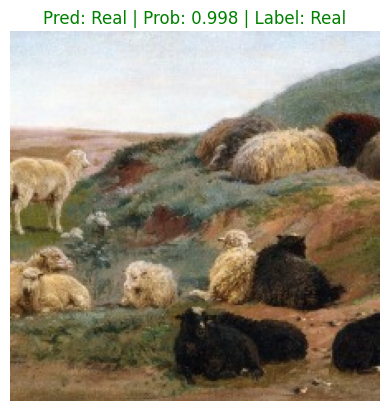

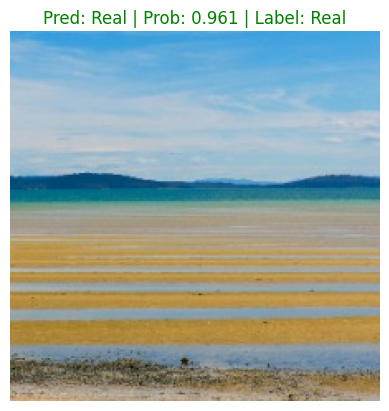

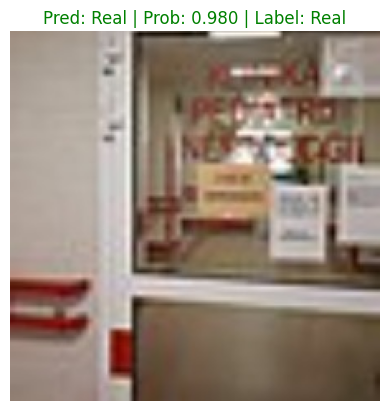

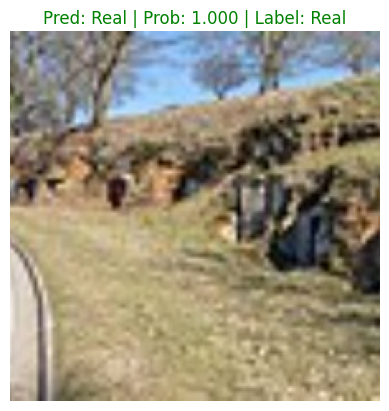

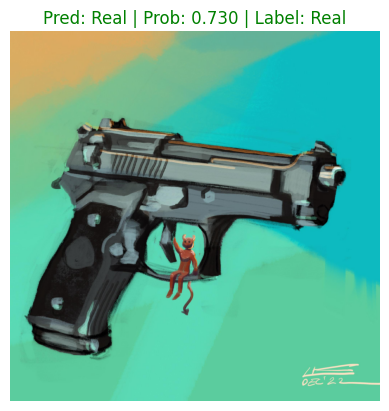

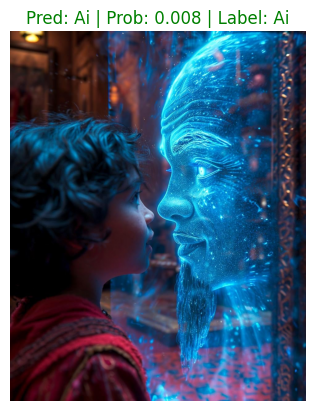

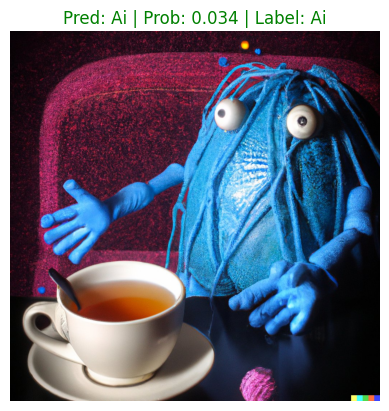

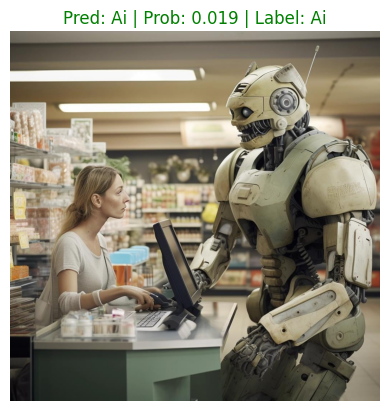

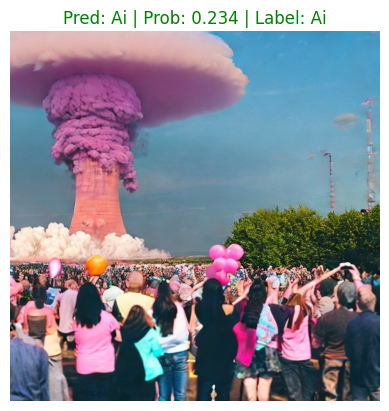

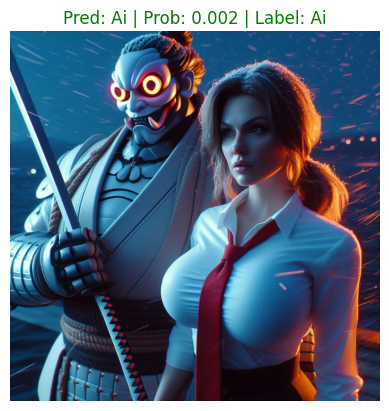

In [31]:
# Randomly selects a set number of real and AI-generated images, applies model predictions, and plots the results with classification labels.

import random
num_images_to_plot = 5
test_real_list = list(Path("/Users/sahilpambhar/Downloads/archive (4)").glob("real/*")) 
test_real_sample = random.sample(population=test_real_list, 
                                       k=num_images_to_plot) 
test_ai_list = list(Path("/Users/sahilpambhar/Downloads/archive (4)/fakeV2").glob("fake-v2/*.jpg")) 
test_ai_sample = random.sample(population=test_ai_list, 
                                       k=num_images_to_plot) 


for image_path in test_real_sample:
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=class_names,
                        transform=weights.transforms(),
                        image_size=(224, 224),
                       label="Real")
for image_path in test_ai_sample:
    pred_and_plot_image(model=model, 
                        image_path=image_path,
                        class_names=class_names,
                        transform=weights.transforms(),
                        image_size=(224, 224),
                       label="Ai")

In [29]:
test_loss, test_acc = test_step(model, test_dataloader, loss_fn, accuracy_fn)
print(f"Accuracy of model on test data: {test_acc * 100 :.3f}%")

Accuracy of model on test data: 87.967%
